Same cosmology as `3-fluid.ipynb`. Computes the GDM parameters $\delta_T$, $w_T$, and ${c_s^2}_T$.

In [2]:
from scipy import integrate
from scipy import interpolate
from scipy.special import spherical_jn
import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt


In [3]:
# Planck Data:
h0 = 0.67
H0 = 100.*h0
OmegaGamma = 2.47e-5/(h0**2.)
OmegaNu = 1.68e-5/(h0**2.)
OmegaRad = OmegaGamma + OmegaNu
OmegaCDM = 0.1201/(h0**2.)
OmegaB = 0.0223/(h0**2.)
OmegaM = OmegaCDM + OmegaB
OmegaLambda = 1-(OmegaCDM + OmegaB + OmegaGamma)
aeq = OmegaRad/OmegaM 

In [4]:
"""function to reset OmegaNu"""
def set_OmegaNu(new_value):
    global OmegaNu
    global OmegaRad
    global aeq
    global ynu
    OmegaNu = 1.68e-5/(h0**2.)
    OmegaRad = OmegaGamma + OmegaNu
    aeq = OmegaRad/OmegaM 
    ynu = OmegaNu/OmegaRad
    

In [5]:
def eta_itgd(a):
    """Conformal time integrand"""
    return 1/(a**2. * H0 * 
              np.sqrt( OmegaM/(a**3) + OmegaRad/(a**4) + OmegaLambda)
             )

# compute conformal time today
(eta_today,_) = integrate.quad(eta_itgd, 0, 1)

# compute conformal time at recombination
(eta_rec,_) = integrate.quad(eta_itgd, 0, 10.**(-3.))

# compute eta_eq
(eta_eq,_) = integrate.quad(eta_itgd, 0, aeq)

In [6]:
zrec = lambda OmB: 1000*OmB**(-0.027/(1 + 0.11 * np.log(OmB)))  
arec = 1/(1 + zrec(OmegaB))
tau_r = 1/(np.sqrt(OmegaM/arec)*H0/2)
zeq  = 1/aeq - 1
alpha = np.sqrt(arec/aeq)
xrec = (np.sqrt((alpha**2 + 1)) - 1)/alpha
xeq = eta_eq/tau_r

In [28]:
# x is time coordinate
# y is scale factor relative to equality
def y(x): return (alpha*x)**2 + 2*alpha*x
def a(x): return aeq*y(x) 
def yb(x): return 1.68*y(x)*OmegaB/OmegaM
def yc(x): return y(x)*OmegaCDM/OmegaM
ynu = OmegaNu/OmegaRad
def eta(x):
    return 2*alpha*(alpha*x + 1)/(alpha**2 * x**2 + 2*alpha*x)
def delta_phi(x):
    return (2-8/y(xrec) + 16*xrec/y(xrec)**3)/(10*y(xrec))
xs = 0.6*OmegaM**(.25) * OmegaB**(-.5)*arec**(.75)*h0**(-.5)
print(eta_rec)
print(tau_r)

0.0009998488836949209
0.0015768908845622794


In [15]:
# initialize arrays and index
SW = np.zeros(1000)
ISW = np.zeros(1000)
DOP = np.zeros(1000)
KAPPA = np.zeros(1000)
it = 0

k_out = np.array([1,50,100,200,500,600,700,800,900])
n_out = 0
x_out = np.linspace(0.,xrec,100)
PHI = np.zeros((len(k_out),100))
DELTA_G = np.zeros((len(k_out),100))
V_G = np.zeros((len(k_out),100))
DELTA_N = np.zeros((len(k_out),100))
V_N = np.zeros((len(k_out),100))
DELTA_C = np.zeros((len(k_out),100))
V_C = np.zeros((len(k_out),100))

i_range = np.linspace(0,4,1000)
for n,i in enumerate(i_range):
    kappa = tau_r * 10**i / eta_today
    xi = np.min([10**-4. / kappa, xeq/10000.])
    phi_i = 1.
    delta_gamma_i = -2.*phi_i*(1 + 3*y(xi)/16.)
    delta_c_i = .75 * delta_gamma_i
    v_gamma_i = -kappa/eta(xi) * (
        delta_gamma_i/4. + (2.*kappa**2 * (1 + y(xi))*phi_i)/
                        (9.*eta(xi)**2. * (4./3. +y(xi))))
    delta_nu_i = delta_gamma_i
    v_nu_i = v_gamma_i
    
    # solve the ODE
    def d_func(x, Y):
        """return function derivatives"""
        delta_c = Y[0]
        vc = Y[1]
        delta_gamma = Y[2]
        v_gamma = Y[3]
        delta_nu = Y[4]
        v_nu = Y[5]
        phi = Y[6]
        
        DY = np.zeros(7)
        DY[6] = -eta(x) * phi + (3*eta(x)**2*(v_gamma*
                        (4./3. +y(x)-yc(x))+ynu*(v_nu-v_gamma)+yc(x)*vc))/(2*(1+y(x))*kappa)
        DY[0] = -kappa * vc + 3*DY[6]
        DY[1] = -eta(x)*vc+kappa*phi
        DY[2] = -4./3. * kappa *v_gamma + 4*DY[6]
        DY[3] = (-eta(x)*yb(x)*v_gamma + kappa*delta_gamma/3)/(
            4./3. + yb(x)) + kappa*phi
        DY[4] = -4./3. * kappa *v_nu + 4*DY[6]
        DY[5] = kappa*delta_nu/4.+ kappa*phi
        
        return DY
    
    x_span = [xi, xrec]
    Y0 = [delta_c_i, v_gamma_i, delta_gamma_i, v_gamma_i,delta_nu_i,v_nu_i, phi_i]
    out = integrate.solve_ivp(d_func, x_span, Y0,max_step=0.01)
    sol = out['y']
    
    # fill arrays
    KAPPA[it] = kappa
    SW[it] = sol[6, -1] + sol[2, -1]/4.
    ISW[it] = 2*delta_phi(xrec)
    DOP[it] = sol[3, -1]
    
    if n in k_out:
        PHI[n_out,:] = np.interp(x_out,out['t'],sol[6])
        DELTA_G[n_out,:] = np.interp(x_out,out['t'],sol[2])
        V_G[n_out,:] = np.interp(x_out,out['t'],sol[3])
        DELTA_N[n_out,:] = np.interp(x_out,out['t'],sol[4])
        V_N[n_out,:] = np.interp(x_out,out['t'],sol[5])
        DELTA_C[n_out,:] = np.interp(x_out,out['t'],sol[0])
        V_C[n_out,:] = np.interp(x_out,out['t'],sol[1])
    
        n_out+=1
    
    it += 1
SW_terp = interpolate.interp1d(KAPPA, -SW * np.exp(-KAPPA**2 * xs**2))
ISW_terp = interpolate.interp1d(KAPPA, -ISW * np.exp(-KAPPA**2 * xs**2))
DOP_terp = interpolate.interp1d(KAPPA, -DOP * np.exp(-KAPPA**2 * xs**2))

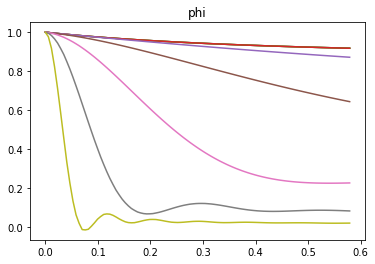

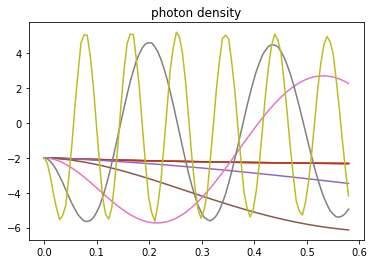

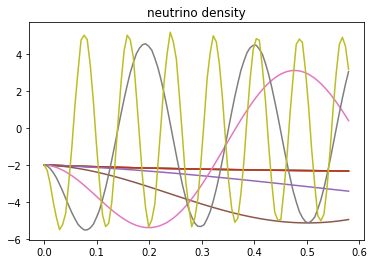

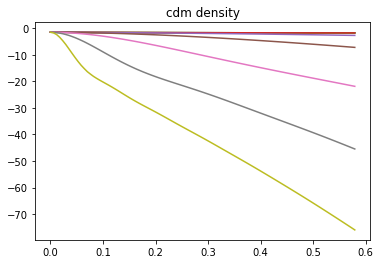

In [23]:
tp = lambda x:np.transpose(x)
plt.plot(x_out,tp(PHI))
plt.title('phi')
plt.show()
plt.title('photon density')
plt.plot(x_out,tp(DELTA_G))
plt.show()
plt.title('neutrino density')
plt.plot(x_out,tp(DELTA_N))
plt.show()
plt.title('cdm density')
plt.plot(x_out,tp(DELTA_C))
plt.show()

In [12]:
#Get delta_T:
    delta_T =(OmegaB*DELTA_G + OmegaCDM*DELTA_C + OmegaGamma*DELTA_G + OmegaNu*DELTA_N)\
    /(OmegaLambda + OmegaM + OmegaRad)

    #get w_eff:
    w_eff =((1./3.)*(OmegaGamma + OmegaNu) - OmegaLambda)\
    /(OmegaLambda + OmegaM + OmegaRad)

    #get cs2_eff:
    cs2_eff =((1./3.)*(OmegaGamma*DELTA_G + OmegaNu*DELTA_N))\
    /(OmegaB*DELTA_G + OmegaCDM*DELTA_C + OmegaGamma*DELTA_G + OmegaNu*DELTA_N)

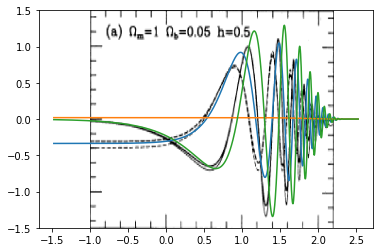

In [17]:
"""Compare to Seljak"""
im = plt.imread('seljak_1.png')
implot = plt.imshow(im, extent=[-1,2.2,-1.5,1.5],aspect='auto',zorder=0)

plt.plot(np.log10(KAPPA), -SW * np.exp(-KAPPA**2 * xs**2))
plt.plot(np.log10(KAPPA), -ISW * np.exp(-KAPPA**2 * xs**2))
plt.plot(np.log10(KAPPA), -DOP * np.exp(-KAPPA**2 * xs**2))
plt.show()